In [11]:
import keras
import numpy as np
import os
import PIL
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import helpers
from pylab import imread, imshow
from skimage.color import rgb2gray
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, core , UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from importlib import reload
helpers = reload(helpers)

In [12]:
def get_opt():
    #All parameters are defualt mentioned in paper
    return Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)



In [13]:
def encoder_conv_block_batch_norm(inputs, n_filters, dropout, kernel_size=3):
    net = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same", activation = 'relu')(inputs)
    net = BatchNormalization()(net)
    net = Dropout(dropout)(net)
    net = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), activation = 'relu', kernel_initializer="he_normal", padding="same")(net)
    net = BatchNormalization()(net)
    return net

In [35]:
def unet_gen(dropout, input_img, transposedConv, n_filters = 32):
    inputs = input_img
    patch_size = 32
    block1 = encoder_conv_block_batch_norm(inputs, n_filters =n_filters,
                                  kernel_size=3, dropout = dropout*0.5)
    pool1 = MaxPooling2D((2, 2))(block1)
    #conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(inputs)
    #conv1 = Dropout(dropout)(conv1)
    #conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv1)
    #pool1 = MaxPooling2D((2, 2))(conv1)
    #
    block2 = encoder_conv_block_batch_norm(pool1, n_filters = n_filters*2,
                                  kernel_size=3, dropout = dropout)
    pool2 = MaxPooling2D((2, 2))(block2) 
    #conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool1)
    #conv2 = Dropout(dropout)(conv2)
    #conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv2)
    #pool2 = MaxPooling2D((2, 2))(conv2)
    #
    bridge = encoder_conv_block_batch_norm(pool2, n_filters = n_filters*4,
                                  kernel_size=3, dropout = dropout)
    
    #conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool2)
    #conv3 = Dropout(dropout)(conv3)
    #conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv3)
    up1 = bridge
    if transposedConv:
        up1 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (up1)
    else:
        up1 = UpSampling2D(size=(2, 2))(up1)
    up1 = concatenate([block2,up1])
    up_block2 = encoder_conv_block_batch_norm(up1, n_filters = n_filters*2,
                                  kernel_size=3, dropout= dropout)
    
    #conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(up1)
    #conv4 = Dropout(dropout)(conv4)
    #conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv4)
    #
    up2 = up_block2
    if transposedConv:
        up2 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (up2)
    else:
        up2 = UpSampling2D(size=(2, 2))(up2)
    up2 = concatenate([block1,up2])
    up_block1 = encoder_conv_block_batch_norm(up2, n_filters = n_filters,
                                  kernel_size=3, dropout = dropout)
    #conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(up2)
    #conv5 = Dropout(dropout)(conv5)
    #conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv5)
    #
    outputs = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(up_block1)
    #conv6 = core.Reshape((2,32*32))(conv6)
    #conv6 = core.Permute((2,1))(conv6)
    ############
    #conv7 = core.Activation('softmax')(conv6)
    opt = get_opt()
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [36]:
def get_transp_conv_unet(dropout, input_img):
    return unet_gen(dropout = dropout, input_img = input_img, transposedConv = True)

In [37]:
def get_up_sample_unet(dropout, input_img):
    return unet_gen(dropout = dropout, input_img = input_img, transposedConv = False)

In [141]:
def get_transp_conv_big_unet(input_img, dropout, n_filters=16):
    inputs = input_img
    block1 = encoder_conv_block_batch_norm(inputs = inputs, n_filters=n_filters*1, dropout = dropout, kernel_size = 3)
    print("block1", block1.shape)
    pool1 = MaxPooling2D((2, 2)) (block1)
    
    block2 = encoder_conv_block_batch_norm(inputs = pool1, n_filters=n_filters*2, dropout = dropout, kernel_size = 3)
    pool2 = MaxPooling2D((2, 2)) (block2)
    print("block2", block2.shape)


    block3 = encoder_conv_block_batch_norm(inputs = pool2, n_filters=n_filters*4, dropout = dropout, kernel_size = 3)
    pool3 = MaxPooling2D((2, 2)) (block3)
    print("block3", block3.shape)


    block4 = encoder_conv_block_batch_norm(inputs = pool3, n_filters=n_filters*8, dropout = dropout, kernel_size = 3)
    print("block4", block4.shape)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (block4)


    bridge = encoder_conv_block_batch_norm(inputs = pool4, n_filters=n_filters*16, dropout = dropout, kernel_size = 3)
    print("bridge", bridge.shape)


    up1 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (bridge)
    print("up1", up1.shape)


    up1 = concatenate([up1, block4])
    up_block1 =  encoder_conv_block_batch_norm(inputs = up1, n_filters=n_filters*8, dropout = dropout, kernel_size = 3)
    
    up2 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (up_block1)
    up2 = concatenate([up2, block3])
    up_block2 = encoder_conv_block_batch_norm(inputs = up2, n_filters=n_filters*4, dropout = dropout, kernel_size = 3)


    up3 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (up_block2)
    up3 = concatenate([up3, block2])
    up_block3 = encoder_conv_block_batch_norm(inputs = up3, n_filters=n_filters*2, dropout = dropout, kernel_size = 3)
    
    up4 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (up_block3)
    up4 = concatenate([up4, block1])
    up_block3 = encoder_conv_block_batch_norm(inputs = up4, n_filters=n_filters*1, dropout = dropout, kernel_size = 3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (up_block3)
    model = Model(inputs=inputs, outputs=outputs)
    opt  = get_opt()
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [142]:
def load_images_from_folder(folder_path):
    file_names = os.listdir(folder_path)
    file_names.sort()
    images = []
    for filename in file_names:
        try:
            image =imread(folder_path + filename)
            images.append(rgb2gray(image).reshape(32,32,1))
        except:
            continue
    return images

In [143]:
def generator(x_train, y_train, batch_size):
    data_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True,
    ).flow(x_train, x_train, batch_size, seed=1)
    mask_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True
    ).flow(y_train, y_train, batch_size, seed=1)
    while True:
        x_batch, _ = data_gen.next()
        y_batch, _ = mask_gen.next()
        yield x_batch, y_batch

## Test data augmentation function

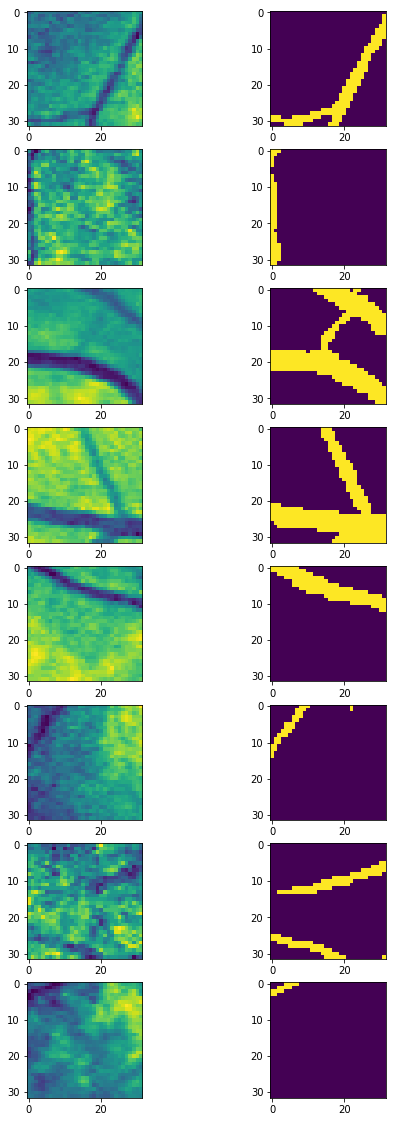

In [144]:

X_train = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
y_train = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
image_batch, mask_batch = next(generator(X_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [145]:
def train(epochs, n_folds, model_dict, saveModel = False):
    X = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
    y = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
    load_model = model_dict['load_model']
    args = model_dict['args']
    model = load_model(**args)
    batch_size = 32
    historyList =[]
    pathToSaveModel = "../../savedModels/"
    if saveModel:
        #if we cant save then we crash here
        model.save(pathToSaveModel + "test.h5")
    if n_folds > 0:
        if (len(X) % n_folds) != 0:
            raise Exception('Same eye in validation and traning set, Patches: ', X_train.shape[1], ' Folds', n_folds)
        sizeFold = len(X) // n_folds
        fold_idx = []
        for fold in range(n_folds):
            for curIdx in range(sizeFold):
                fold_idx.append(fold)
        fold_idx = np.array(fold_idx)
    
        for fold in range(n_folds):
            train_idx = fold_idx != fold
            test_idx = fold_idx == fold
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]
            model = load_model(**args)
            earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
            mcp_save = ModelCheckpoint('.mdl_wtsPL.hdf5', save_best_only=True, monitor='val_loss', mode='min')
            #reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1, epsilon=1e-4, mode='min')
            history = model.fit_generator(generator(X_train, y_train, batch_size = batch_size),
                                  epochs = epochs, steps_per_epoch = len(X_train)//batch_size,
                                          callbacks=[earlyStopping, mcp_save],
                                             validation_data = (X_test,y_test))
            historyList.append(history)
    elif saveModel or (n_folds == 0):
        model = load_model(**args)
        history = model.fit_generator(generator(X, y, batch_size = batch_size),
                                      epochs = epochs, steps_per_epoch = len(X)//batch_size)
        historyList.append(history)
        if saveModel:
            model.save(pathToSaveModel+model_dict['name']+".h5")
    return model, historyList
    

## Train model on the full data set, no cross validation

In [146]:
args1 = {'input_img' : Input((32,32,1)), 'dropout' : 0.2}
model_dict = {'load_model' : get_transp_conv_big_unet, 'args' : args1}
chase_model, historyList = train(epochs = 100, n_folds = 0, model_dict = model_dict)


block1 (?, 32, 32, 16)
block2 (?, 16, 16, 32)
block3 (?, 8, 8, 64)
block4 (?, 4, 4, 128)
bridge (?, 2, 2, 256)
up1 (?, ?, ?, 128)
block1 (?, 32, 32, 16)
block2 (?, 16, 16, 32)
block3 (?, 8, 8, 64)
block4 (?, 4, 4, 128)
bridge (?, 2, 2, 256)
up1 (?, ?, ?, 128)
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
62/62 [==============================] - 30s 477ms/step - loss: 0.6565
Epoch 2/100
24/62 [==========>...................] - ETA: 11s - loss: 0.5159

KeyboardInterrupt: 

## Compare 3 models with different dropout

In [ ]:
def train_3_models_dropout():
    epochs = 1
    model_name = ["TranspConv", "Seismic", "UpSample"]

    load_model = [get_transp_conv_unet, get_unet_seismic, get_up_sample_unet]

    dropouts = [0]

    model_dicts = []
    for dropout in dropouts:
        for model_idx in range(len(model_name)):
            arg = {}
            arg['dropout'] = dropout
            arg['input_img'] = Input((32,32,1))
            model_dict = {}
            model_dict['load_model'] = load_model[model_idx]
            model_dict['args'] = arg
            model_dict['name'] = model_name[model_idx] + str(dropout)
            model_dicts.append(model_dict)


    models = []
    historyLists =[]
    for model_dict in model_dicts:
        print(model_dict['name'])
        model, historyList = train(epochs = epochs, n_folds = 2, model_dict = model_dict)
        models.append(model)
        historyLists.append(historyList)
    return historyLists, model_dicts,models

In [ ]:
#historyLists, model_dicts, models = train_3_models_dropout()

In [ ]:
def plotMultipleModels(full_model_history_df):
    plt.style.use('ggplot')
    ax = sns.lineplot(x="epochs", y="loss", style="type", hue= 'model', data=full_model_history_df, ci = None)
    legend = ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    %config InlineBackend.figure_format = 'retina'
    ax.legend(loc='upper center', bbox_to_anchor= (1.11, 1), shadow=True, fontsize = 'large')
    #ax.set_ylim(0.32,0.4)
    ax.set_title('Three architectures with diffrent dropout rates', fontSize = 18)
    ax.set_xlabel('epochs',fontSize = 16)
    ax.set_ylabel('loss', fontSize = 16)
    sns.set(rc={'figure.figsize':(14,11)})
    #ax.set_ylim(0.34,0.4)
    #ax.set_xlim(10,50)

    plt.show()

In [ ]:
def plotComparisonOfModels( historyLists, model_dicts):
    full_model_history_df = pd.DataFrame()
    for cur_model_nr in range(len(model_dicts)):
        loss_data = ([i.history['loss'] for i in historyLists[cur_model_nr]])
        val_loss_data = ([i.history['val_loss'] for i in historyLists[cur_model_nr]])
        all_data = loss_data + val_loss_data
        all_data.append( [i+1 for i in range(len(historyLists[cur_model_nr][0].history['val_loss']))])
        model_history_df = pd.DataFrame(all_data).T
        column_names = []
        foldLossName = []
        for i in range(len(loss_data)):
            foldLossName.append("fold"+str(i)+"_loss")
        column_names += foldLossName
        foldValLossName = []
        for i in range(len(val_loss_data)):
            foldValLossName.append("fold"+str(i)+"val_loss")
        column_names += foldValLossName
        column_names.append('epochs')
        model_history_df.columns=column_names
        model_history_df["model"] = model_dicts[cur_model_nr]['name']
        #plt.plot(history.history['loss'])
        #plt.plot(history.history['val_loss'])
        #plt.xlabel("epoch")
        #plt.ylabel("loss")
        #plt.show()
        model_history_df = pd.melt(model_history_df, value_vars=foldLossName+ foldValLossName,
                                   id_vars = ['epochs','model'] ,value_name = "loss")
        types = ['train', 'validation']
        trainOrValidation = []
        for i in types:
            for j in range(model_history_df.shape[0]//2):
                trainOrValidation.append(i)
        model_history_df['type'] =trainOrValidation
        model_history_df = model_history_df.astype({'epochs': int})
        full_model_history_df = pd.concat([full_model_history_df, model_history_df], ignore_index = True)
    full_model_history_df.to_pickle("fullModelHistorydf.pkl")
    plotMultipleModels(full_model_history_df)


In [ ]:
plotComparisonOfModels(historyLists, model_dicts)

In [ ]:
def best_model_more_detailed():
    epochs = 150
    model_name = ["TranspConv", "UpSample"]

    load_model = [get_transp_conv_unet, get_up_sample_unet]

    dropouts = [0.05, 0.2]
    model_dicts = []
    for dropout in dropouts:
        for model_idx in range(len(model_name)):
            arg = {}
            arg['dropout'] = dropout
            arg['input_img'] = Input((32,32,1))
            model_dict = {}
            model_dict['load_model'] = load_model[model_idx]
            model_dict['args'] = arg
            model_dict['name'] = model_name[model_idx] + str(dropout)
            model_dicts.append(model_dict)
    models = []
    historyLists =[]
    for model_dict in model_dicts:
        print(model_dict['name'])
        model, historyList = train(epochs = epochs, n_folds = 4, model_dict = model_dict)
        models.append(model)
        historyLists.append(historyList)
    return historyLists, model_dicts, models

In [ ]:
historyLists_detail, model_dicts_detail, models_detail = best_model_more_detailed()

In [ ]:
plotComparisonOfModels(historyLists_detail, model_dicts_detail)

In [ ]:
nr_of_images = 10
fig, ax = plt.subplots(nr_of_images,4, figsize=(8,20))
fig.tight_layout()
for image_nr in range(nr_of_images):
    ax[image_nr,0].imshow(X_train[image_nr].reshape(32,32))
    ax[image_nr,1].imshow(y_train[image_nr].reshape(32,32))
    y_pred = res.predict(X_train[image_nr:(image_nr+1)]).reshape(32,32)
    y_pred_thr = y_pred.copy()
    y_pred_thr[y_pred > 0.5] = 1
    y_pred_thr[y_pred <= 0.5] = 0
    ax[image_nr,2].imshow(y_pred)
    ax[image_nr,3].imshow(y_pred_thr)
    for j in range(4):
        ax[image_nr,j].set_xticklabels([])
        ax[image_nr,j].set_yticklabels([])
plt.show()



In [ ]:
drive_test_images = helpers.load_images_from_folder(helpers.DRIVE_TEST_IMAGES_PATH)
drive_test_mask = helpers.load_images_from_folder(helpers.DRIVE_TEST_MASK_PATH)
drive_test_segmented = helpers.load_images_from_folder(helpers.DRIVE_TEST_SEG_1_PATH)

drive_training_images = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_IMAGES_PATH)
drive_training_mask = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_MASK_PATH)
drive_training_segmented = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_SEG_1_PATH)

chase_training_images = helpers.load_images_from_folder(helpers.CHASE_IMAGES_PATH)
chase_training_mask = helpers.load_images_from_folder(helpers.CHASE_MASK_PATH)
chase_training_segmented = helpers.load_images_from_folder(helpers.CHASE_SEG_1_PATH)

In [ ]:
def get_test_score(images, mask, segmentation, model, plot=False, nr_of_images=None ):
    if not nr_of_images:
        nr_of_images = len(images)
    total_auc_score = 0
    total_accuracy = 0
    total_sensitivity = 0
    total_specificity = 0
    if plot:
        fig, ax = plt.subplots(nr_of_images,3, figsize=(20,20))
    for (i, image) in enumerate(images[:nr_of_images]):
        print('Segmenting image',(i+1))
        full_image_segmentation = helpers.segment_whole_image(image, mask[i], 32, helpers.Dataset.DRIVE, model)
        total_auc_score += helpers.roc_auc(full_image_segmentation, segmentation[i], mask[i])
        total_accuracy += helpers.accuracy(full_image_segmentation, segmentation[i], mask[i])
        total_sensitivity += helpers.sensitivity(full_image_segmentation, segmentation[i], mask[i])
        total_specificity += helpers.specificity(full_image_segmentation, segmentation[i], mask[i])
        if plot:
            ax[i, 0].imshow(full_image_segmentation)
            ax[i, 1].imshow(segmentation[i])
            ax[i, 2].imshow(image)
            
    print('Average auc score: ', total_auc_score/nr_of_images)
    print('Average accuracy score: ', total_accuracy/ nr_of_images )
    print('Average sensitivity score: ', total_sensitivity/ nr_of_images )
    print('Average specificity score: ', total_specificity/nr_of_images )
    if plot:
        plt.show()
            

In [ ]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, final_model_more_data, False, 20)

In [ ]:
final_model_more_data = load_model('../../savedModels/bestLong')

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(20,20))
full_image_segmentation = helpers.segment_whole_image(drive_test_images[0], drive_test_mask[0], 32, helpers.Dataset.DRIVE, final_model_more_data)
ax[0,0].imshow(full_image_segmentation)
full_image_segmentation[full_image_segmentation > 0.5] = 1
full_image_segmentation[full_image_segmentation <= 0.5] = 0
ax[0,1].imshow(full_image_segmentation)
ax[0,2].imshow(drive_test_segmented[0])
ax[0,3].imshow(drive_test_images[0])

full_image_segmentation = helpers.segment_whole_image(drive_test_images[1], drive_test_mask[1], 32, helpers.Dataset.DRIVE, final_model_more_data)
ax[1,0].imshow(full_image_segmentation)
full_image_segmentation[full_image_segmentation > 0.5] = 1
full_image_segmentation[full_image_segmentation <= 0.5] = 0
ax[1,1].imshow(full_image_segmentation)
ax[1,2].imshow(drive_test_segmented[1])
ax[1,3].imshow(drive_test_images[1])

plt.show()

In [ ]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, final_model_more_data, True, 2)

In [ ]:
final_model_more_data.save('../../savedModels/bestLong')

In [ ]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, final_model_no_stop, True, 3)

In [ ]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, final_model_no_stop, False, 20)

In [ ]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, transfer_model3, False, 20)

In [ ]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, drive_model, False, 20)

In [ ]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, chase_model, False, 20)

In [ ]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, transfer_model4, False, 20)

In [ ]:
def create_patches(images, segmentations, masks, n, patches_per_image):
    nrOfImages = 0
    for (i, image) in enumerate(images):
        patch_images, patch_labels = helpers.get_image_pathes(image, segmentations[i], n, patches_per_image, helpers.Dataset.DRIVE, masks[i])
        for (j, patch) in enumerate(patch_images):
            name = str(i) + '_' + str(j)
            helpers.save_image('../../data/DRIVE/training/patches/' + name + '.png', patch)
            helpers.save_image('../../data/DRIVE/training/patchLabels/' + name + '.png' , patch_labels[j])
            nrOfImages += 1

In [ ]:
create_patches(drive_training_images, drive_training_segmented, drive_training_mask, 32, 1000)

In [ ]:
def transfer_train(model, epochs, layers, n_folds=0):
    transfer_model = model
    for layer in transfer_model.layers[: 16]:
        layer.trainable = False 
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    transfer_model.compile(optimizer = opt, loss = 'binary_crossentropy')
    X = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
    y = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
    batch_size = 32
    historyList =[]
    if n_folds > 0:
        if (len(X) % n_folds) != 0:
            raise Exception('Same eye in validation and traning set, Patches: ', X_train.shape[1], ' Folds', n_folds)
        sizeFold = len(X) // n_folds
        fold_idx = []
        for fold in range(n_folds):
            for curIdx in range(sizeFold):
                fold_idx.append(fold)
        fold_idx = np.array(fold_idx)
    
        for fold in range(n_folds):
            train_idx = fold_idx != fold
            test_idx = fold_idx == fold
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]
            transfer_model = copy_model(model)
            for layer in transfer_model.layers[: -8*layers]:
                layer.trainable = False
            opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            transfer_model.compile(optimizer = opt, loss = 'binary_crossentropy')
            history = transfer_model.fit_generator(generator(X_train, y_train, batch_size = batch_size),
                                  epochs = epochs, steps_per_epoch = len(X_train)//batch_size,
                                         validation_data = (X_test,y_test))
            historyList.append(history)
    elif n_folds == 0:
        history = transfer_model.fit_generator(generator(X, y, batch_size = batch_size),
                                      epochs = epochs, steps_per_epoch = len(X)//batch_size)
        historyList.append(history)
    return transfer_model, historyList

In [ ]:
def transfer_vs_transConv(model):
    model_dicts = []
    historyLists = []
    models = []
    epochs = 5
    frozenBlocks = [1]
    model_names = ['TransferLearningB1', 'TransferLearningB2', 'TransferLearningB3', 'TransferLearningB4']
    for model_name_idx in range(len(model_names)):
        model_transf, history_transf = transfer_train(model= model,
                                                      epochs = epochs, layers= frozenBlocks[model_name_idx], n_folds = 4)
        model_dict = {'name' : model_names[model_name_idx]}
        model_dicts.append(model_dict)
        historyLists.append(history_transf) 
        models.append(model_transf)
    return historyLists, model_dicts, models
    


In [ ]:
#historyLists_transf.append(historyLists_detail[2])
#model_dicts_transf.append(model_dicts_detail[2])
#models_transf.append(models_detail[2])
plotComparisonOfModels([_], [])

In [ ]:
transfer_model4, t = transfer_train(chase_model, 100, 1)

In [ ]:
def copy_model(model):
    model_copy= keras.models.clone_model(model)
    model_copy.build() 
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model_copy.compile(optimizer = opt, loss = 'binary_crossentropy')
    model_copy.set_weights(model.get_weights())
    return model_copy

In [ ]:
print(chase_model.summary())
print(len(chase_model.layers))